In [1]:
%load_ext autoreload
%autoreload 2



In [2]:
## Load modules
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import pickle
import sys
sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
from data_preprocessing_helpers import get_lonlatbox
sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
from plot_functions import plot_cross_section, draw_color_blocks, add_inset_plot
sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions

import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

In [20]:
ds_p.time

<xarray.DataArray 'time' (time: 73)>
array(['2017-04-08T12:00:00.000000000', '2017-04-08T13:00:00.000000000',
       '2017-04-08T14:00:00.000000000', '2017-04-08T15:00:00.000000000',
       '2017-04-08T16:00:00.000000000', '2017-04-08T17:00:00.000000000',
       '2017-04-08T18:00:00.000000000', '2017-04-08T19:00:00.000000000',
       '2017-04-08T20:00:00.000000000', '2017-04-08T21:00:00.000000000',
       '2017-04-08T22:00:00.000000000', '2017-04-08T23:00:00.000000000',
       '2017-04-09T00:00:00.000000000', '2017-04-09T01:00:00.000000000',
       '2017-04-09T02:00:00.000000000', '2017-04-09T03:00:00.000000000',
       '2017-04-09T04:00:00.000000000', '2017-04-09T05:00:00.000000000',
       '2017-04-09T06:00:00.000000000', '2017-04-09T07:00:00.000000000',
       '2017-04-09T08:00:00.000000000', '2017-04-09T09:00:00.000000000',
       '2017-04-09T10:00:00.000000000', '2017-04-09T11:00:00.000000000',
       '2017-04-09T12:00:00.000000000', '2017-04-09T13:00:00.000000000',
       '2017-04-09T14:00:00.000000000', '2017-04-09T15:00:00.000000000',
       '2017-04-09T16:00:00.000000000', '2017-04-09T17:00:00.000000000',
       '2017-04-09T18:00:00.000000000', '2017-04-09T19:00:00.000000000',
       '2017-04-09T20:00:00.000000000', '2017-04-09T21:00:00.000000000',
       '2017-04-09T22:00:00.000000000', '2017-04-09T23:00:00.000000000',
       '2017-04-10T00:00:00.000000000', '2017-04-10T01:00:00.000000000',
       '2017-04-10T02:00:00.000000000', '2017-04-10T03:00:00.000000000',
       '2017-04-10T04:00:00.000000000', '2017-04-10T05:00:00.000000000',
       '2017-04-10T06:00:00.000000000', '2017-04-10T07:00:00.000000000',
       '2017-04-10T08:00:00.000000000', '2017-04-10T09:00:00.000000000',
       '2017-04-10T10:00:00.000000000', '2017-04-10T11:00:00.000000000',
       '2017-04-10T12:00:00.000000000', '2017-04-10T13:00:00.000000000',
       '2017-04-10T14:00:00.000000000', '2017-04-10T15:00:00.000000000',
       '2017-04-10T16:00:00.000000000', '2017-04-10T17:00:00.000000000',
       '2017-04-10T18:00:00.000000000', '2017-04-10T19:00:00.000000000',
       '2017-04-10T20:00:00.000000000', '2017-04-10T21:00:00.000000000',
       '2017-04-10T22:00:00.000000000', '2017-04-10T23:00:00.000000000',
       '2017-04-11T00:00:00.000000000', '2017-04-11T01:00:00.000000000',
       '2017-04-11T02:00:00.000000000', '2017-04-11T03:00:00.000000000',
       '2017-04-11T04:00:00.000000000', '2017-04-11T05:00:00.000000000',
       '2017-04-11T06:00:00.000000000', '2017-04-11T07:00:00.000000000',
       '2017-04-11T08:00:00.000000000', '2017-04-11T09:00:00.000000000',
       '2017-04-11T10:00:00.000000000', '2017-04-11T11:00:00.000000000',
       '2017-04-11T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-04-08T12:00:00 ... 2017-04-11T12:00:00

In [23]:
## Load Data
lonrange = [135,-165]
latrange = [20,70]


path = '/net/thermo/atmosdyn2/atroman/PACaccu/cdf'

ds_p_all = xr.open_mfdataset(f'{path}/P*')
ds_p_all = ds_p_all.squeeze('lev2')
da_rh = xr.open_dataset('/home/freimax/msc_thesis/data/case_study_ra19/model_level_coord/RH_ifs.nc')

## Lonlatbox  -- apply to model-level data
ds_p = get_lonlatbox(ds_p_all, lon_range=lonrange, lat_range=latrange)
ds_p['tsubsi']  = ds_p['tsubs'] + ds_p['tsubi']

ds_p['tmeltsi'] = ds_p['tmelts']+ ds_p['tmelti']
ds_p['SIWC']    = ds_p['SWC']+ ds_p['IWC']
ds_p['RH_ifs']  = da_rh['RH_ifs']
## Subselect dataset around cyclone center
ds_p_subset  = ds_p.sel(time=slice('20170410-13', '20170410-22'), lon=slice(150,185), lat=slice(30,60) )

ds_p_subset  = ds_p.sel(time=slice('20170409-20', '20170411-08'), lon=slice(150,185), lat=slice(30,60) )

In [24]:
ds_p_subset

,Array,Chunk
Bytes,78.35 MiB,1.83 MiB
Shape,"(37, 83, 76, 88)","(1, 83, 76, 76)"
Count,731 Tasks,74 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,78.35 MiB,1.83 MiB
Shape,"(37, 83, 76, 88)","(1, 83, 76, 76)"
Count,731 Tasks,74 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [25]:
X_train_tevr, X_test_tevr, y_train_tevr, y_test_tevr = rf_functions.get_train_test_split(ds_p=ds_p_subset, 
                                                                                         bcp='tevr', 
                                                                                         save=False)


Create feature dataframe for tevr

Apply domain filter (RWC > 0)
Drop all points where RWC == 0
Filtered dataframe size:	2.31e+06 	11.2% of size compared to unfiltered. (Points dropped: 18231525)
Class 0 fraction (before drop):	98.9%

Class Balance New Dataframe:
------------------------------
Class 0 fraction:	91.1%		2102497 Points
Class 1 fraction:	8.4%		 193641 Points
Class 2 fraction:	 0.5%		  11185 Points
------------------------------		--------------
Toatal points in new df:		2307323 Points

Scale Temperature values
Applying z-scaling...
          bcp_label           RWC        RH_ifs          Temp            CC  \
count  2.307323e+06  2.307323e+06  2.307323e+06  2.307323e+06  2.307323e+06   
mean   9.361975e-02  1.767528e-02  8.743984e-01 -4.470154e-07  2.219130e-01   
std    3.097891e-01  3.338724e-02  1.223823e-01  9.993096e-01  3.657992e-01   
min    0.000000e+00  2.980232e-05  2.603597e-03 -2.416725e+00  0.000000e+00   
25%    0.000000e+00  2.384186e-04  8.180176e-01 -8.879

---

### TevR model

In [35]:
def find_best_parameters_tevr(X_train, y_train):
    class_weights = [{0: 1, 1: x, 2:y} for x in [2,3] for y in [8,9,10,]]
    max_depths = [9]
    trees = [500, 600]
    
    best_params = None
    best_score = -1
    best_rf_classifier = None

    # Create a custom scorer using F1 score
    f1_scorer = make_scorer(f1_score, average='macro')

    # Iterate over the parameter grid and train the models sequentially
    for class_weight in class_weights:
        for max_depth in max_depths:
            for n_trees in trees:
                print(f"Training with class_weight={class_weight}, max_depth={max_depth}, and n_trees={n_trees}")

                rf_classifier = RandomForestClassifier(n_estimators=n_trees,
                                                       criterion='gini',
                                                       max_depth=max_depth,
                                                       max_features='sqrt',
                                                       oob_score=True,
                                                       verbose=0,
                                                       n_jobs=-2,
                                                       class_weight=class_weight,
                                                       random_state=42)

                # Perform cross-validation and calculate the mean F1 score
                scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring=f1_scorer)
                mean_score = np.mean(scores)

                # Update the best parameters and score if necessary
                if mean_score > best_score:
                    best_params = {'class_weight': class_weight, 'max_depth': max_depth, 'n_trees': n_trees}
                    best_score = mean_score
                    best_rf_classifier = rf_classifier

                print(f"Mean F1 score: {mean_score}")

    # Print the best parameters and score
    print("Best parameters: ", best_params)
    print("Best score: ", best_score)

    # Fit the best model to the entire training data
    best_rf_classifier.fit(X_train, y_train)

    # Return the best estimator
    return best_rf_classifier

In [36]:
best_rf_classifier_tevr = find_best_parameters_tevr(X_train_tevr, y_train_tevr)

Training with class_weight={0: 1, 1: 2, 2: 8}, max_depth=9, and n_trees=500
Mean F1 score: 0.7691596197395605
Training with class_weight={0: 1, 1: 2, 2: 8}, max_depth=9, and n_trees=600
Mean F1 score: 0.7691383348712061
Training with class_weight={0: 1, 1: 2, 2: 9}, max_depth=9, and n_trees=500
Mean F1 score: 0.7660802967171204
Training with class_weight={0: 1, 1: 2, 2: 9}, max_depth=9, and n_trees=600
Mean F1 score: 0.7658760249616253
Training with class_weight={0: 1, 1: 2, 2: 10}, max_depth=9, and n_trees=500
Mean F1 score: 0.7617328953640273
Training with class_weight={0: 1, 1: 2, 2: 10}, max_depth=9, and n_trees=600
Mean F1 score: 0.7616146155524215
Training with class_weight={0: 1, 1: 3, 2: 8}, max_depth=9, and n_trees=500
Mean F1 score: 0.7599751900727918
Training with class_weight={0: 1, 1: 3, 2: 8}, max_depth=9, and n_trees=600
Mean F1 score: 0.7599345806775227
Training with class_weight={0: 1, 1: 3, 2: 9}, max_depth=9, and n_trees=500
Mean F1 score: 0.7621867270230999
Training

============================  Test  ============================
Confusion matrix:
[[406367  14456     40]
 [  6786  30113   1481]
 [    40    468   1714]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97    420863
         1.0       0.67      0.78      0.72     38380
         2.0       0.53      0.77      0.63      2222

    accuracy                           0.95    461465
   macro avg       0.73      0.84      0.77    461465
weighted avg       0.96      0.95      0.95    461465



<AxesSubplot:>

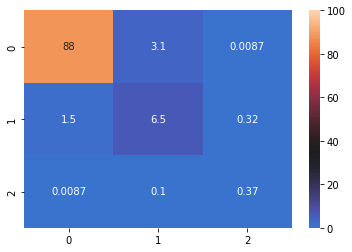

In [26]:
###############
## Tevr model #
###############

class_weights = {0:1, 1:2, 2:9}
# Train forest for the tevr
rf_classifier_tevr = RandomForestClassifier(n_estimators=500,
                                            criterion='gini', 
                                            max_depth=10,
                                            max_features= 'sqrt',                         # 'sqrt',          # The number of features to consider when looking for the best split
                                            oob_score=True,
                                            verbose=0,
                                            n_jobs=-1,
                                            class_weight= class_weights,                #class_weights,   #balanced , “balanced_subsample”,
                                            random_state=42)
# Fit Forest
rf_classifier_tevr.fit(X_train_tevr, y_train_tevr)

# Predict and evaluate the model for the tevr process
y_pred_model_tevr = rf_classifier_tevr.predict(X_test_tevr)
cm_tevr = rf_functions.get_confmat_clasreport(y_test_tevr, y_pred_model_tevr, model='Test')

sns.heatmap(cm_tevr*100/np.sum(cm_tevr), annot=True, center=35,vmax=100,vmin=0)

In [27]:
feature_list = ['RWC', 'RH_ifs', 'Temp', 'CC', 'W']

# Get numerical feature importances
importances = list(rf_classifier_tevr.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: RH_ifs               Importance: 0.65
Variable: RWC                  Importance: 0.14
Variable: CC                   Importance: 0.08
Variable: W                    Importance: 0.07
Variable: Temp                 Importance: 0.06


[None, None, None, None, None]

In [8]:
## Save random forest classifier
path = '/home/freimax/msc_thesis/scripts/random_forest/models'
with open(f'{path}/rf_classifier_tevr.pickle', 'wb') as f:
    pickle.dump(rf_classifier_tevr, f)

---
---
## Apply random forest on different timesteps

In [28]:
ds_p_all = xr.open_mfdataset('/net/thermo/atmosdyn2/atroman/PACaccu/cdf/P*')
ds_p_all = ds_p_all.squeeze('lev2')
da_rh = xr.open_dataset('/home/freimax/msc_thesis/data/case_study_ra19/model_level_coord/RH_ifs.nc')

lonrange = [135,-165]
latrange = [20,70]
ds_p = get_lonlatbox(ds_p_all, lon_range=lonrange, lat_range=latrange)

ds_p['tsubsi']  = ds_p['tsubs'] + ds_p['tsubi']
ds_p['tmeltsi'] = ds_p['tmelts']+ ds_p['tmelti']
ds_p['SIWC']    = ds_p['SWC']+ ds_p['IWC']

In [29]:
### Select time frame for verification
ds_p_t1 = ds_p.isel(time=slice(50,55))
da_rh_t1 = da_rh.isel(time=slice(50,55))
ds_p_t1['RH_ifs'] = da_rh_t1['RH_ifs']

In [11]:
da_rh_t1.time

<xarray.DataArray 'time' (time: 5)>
array(['2017-04-10T14:00:00.000000000', '2017-04-10T15:00:00.000000000',
       '2017-04-10T16:00:00.000000000', '2017-04-10T17:00:00.000000000',
       '2017-04-10T18:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-04-10T14:00:00 ... 2017-04-10T18:00:00

In [30]:

## Choose Model
model = rf_classifier_tevr


#-------------------------------------------------------------
# Get ground-truth, predcitons and baseline for new timeframe
#-------------------------------------------------------------

## Get a data-array with the predicitons
print('Make random forest predictions')
da_y_pred_tevr = rf_functions.predict_bcp_labels(ds=ds_p_t1, rf_classifier=model, water_type='RWC', feature_names = ['RWC', 'RH_ifs', 'T', 'CC', 'OMEGA'], type_filteredvalues='zero')
da_y_pred_tevr_binary = da_y_pred_tevr.where(da_y_pred_tevr != 2, 1) 
np_y_pred_tevr = da_y_pred_tevr.values.flatten()
np_y_pred_tevr_binary = da_y_pred_tevr_binary.values.flatten()

Make random forest predictions

Predict labels using random forest
-------------------------------------------------------------------------------------------------------------
Create df_features
Apply domain-filter(s) to df_features:
Drop all points where RWC == 0

Scale Temperature values
Applying z-scaling...
                 RWC         RH_ifs          Temp             CC  \
count  828904.000000  828904.000000  8.289040e+05  828904.000000   
mean        0.014310       0.861533  4.325972e-10       0.168837   
std         0.043474       0.129039  9.998438e-01       0.311946   
min         0.000002       0.004650 -3.637928e+00       0.000000   
25%         0.000238       0.809677 -8.513529e-01       0.000000   
50%         0.001192       0.885046 -5.532753e-02       0.000000   
75%         0.006974       0.948503  8.235046e-01       0.140625   
max         0.946462       1.171908  2.248322e+00       1.000000   

                   W  
count  828904.000000  
mean       -0.056205  
std 

In [31]:

## Get the Ground-truth values
print('Get the true labels for the bcp-processes')
da_y_true_tevr = rf_functions.get_y_true(data_array=ds_p_t1.tevr, thresholds={'weak':-0.05,'medium':-0.5})
np_y_true_tevr = da_y_true_tevr.values.flatten()
da_y_true_tevr_binary = da_y_true_tevr.where(da_y_true_tevr != 2, 1) 
np_y_true_tevr_binary  = da_y_true_tevr_binary.values.flatten()


## Get the Baseline predictions
print('Get the baseline labels for the bcp-processes')
da_y_baseline_tevr = rf_functions.get_y_baseline(input_data=ds_p_t1, bcp='tevr', thr_vars=['RWC','RH_ifs'], thr_metrics = '50%')
np_y_baseline_tevr = da_y_baseline_tevr.values.flatten()

Get the true labels for the bcp-processes
Get the baseline labels for the bcp-processes


In [32]:
a=rf_functions.get_confmat_clasreport(np_y_true_tevr_binary, np_y_pred_tevr_binary, model='RandomForest')
a=rf_functions.get_confmat_clasreport(np_y_true_tevr_binary, np_y_baseline_tevr   , model='Baseline')


============================  RandomForest  ============================
Confusion matrix:
[[7731787   17446]
 [  27841   66426]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   7749233
         1.0       0.79      0.70      0.75     94267

    accuracy                           0.99   7843500
   macro avg       0.89      0.85      0.87   7843500
weighted avg       0.99      0.99      0.99   7843500

============================  Baseline  ============================
Confusion matrix:
[[7312169  437064]
 [  34676   59591]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97   7749233
         1.0       0.12      0.63      0.20     94267

    accuracy                           0.94   7843500
   macro avg       0.56    

In [33]:
## Print classification report only for RF-model (with 3 classes)
a=rf_functions.get_confmat_clasreport(np_y_true_tevr, np_y_pred_tevr, model='RandomForest')

============================  RandomForest  ============================
Confusion matrix:
[[7731787   17423      23]
 [  27725   58305    2275]
 [    116    2726    3120]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   7749233
         1.0       0.74      0.66      0.70     88305
         2.0       0.58      0.52      0.55      5962

    accuracy                           0.99   7843500
   macro avg       0.77      0.73      0.75   7843500
weighted avg       0.99      0.99      0.99   7843500



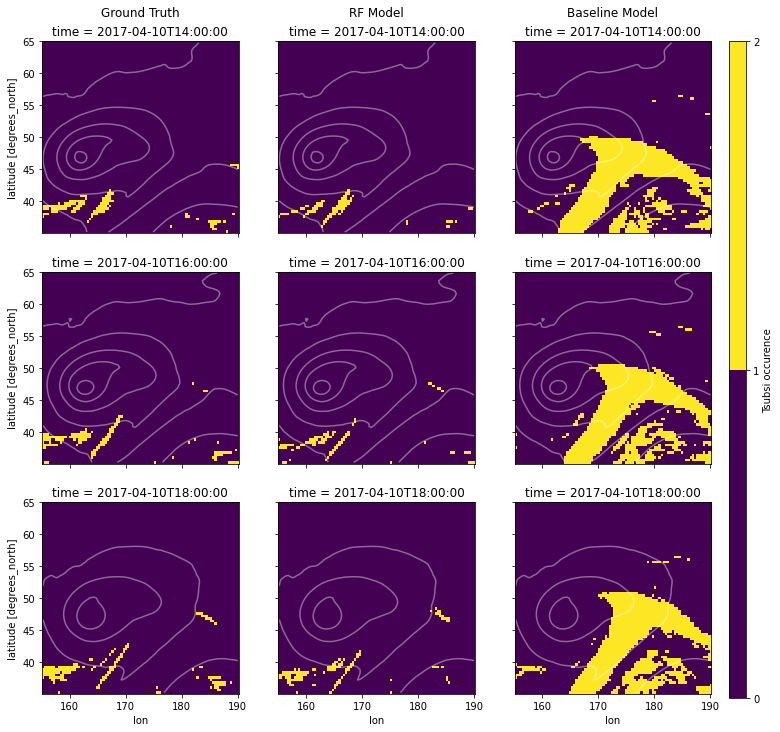

In [34]:
level = 10
#level = 'sum'

lon_min = 155
lon_max = 190

lat_min = 35
lat_max = 65 
#--------------------------------------------------------------------------------
if level == 'sum':
    y_abstruth = da_y_true_tevr.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).sum(dim='lev')
    y_baseline = da_y_baseline_tevr.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).sum(dim='lev')
    y_rf_model = da_y_pred_tevr.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).sum(dim='lev')
    da_slp     = ds_p_t1.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
elif isinstance(level, int) :
    y_abstruth = da_y_true_tevr.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), lev=level)
    y_baseline = da_y_baseline_tevr.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), lev=level)
    y_rf_model = da_y_pred_tevr.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), lev=level)
    da_slp     = ds_p_t1.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# Get the middle timestep
middle_timestep = da_y_true_tevr.time.size // 2
# Extract and slice the DataArrays for each timestep
timesteps = [0, middle_timestep, -1]

data_arrays = [
    [y_abstruth.isel(time=t) for t in timesteps],
    [y_rf_model.isel(time=t) for t in timesteps], 
    [y_baseline.isel(time=t) for t in timesteps], 
               ]
slp_array=[da_slp.SLP.isel(time=t) for t in timesteps]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharex=True, sharey=True)
titles = ['Ground Truth', 'RF Model', 'Baseline Model', ]
for col, data_row in enumerate(data_arrays):
    for row, data in enumerate(data_row):
        ax = axes[row][col]
        # Plot the data
        im = data.plot.imshow(ax=ax, add_colorbar=False, add_labels=True, levels=[0,1,2 ])
        slp_array[row].plot.contour(ax=ax, colors='white', alpha=0.4)
        # Remove labels from the internal axes
        if col != 0:
            ax.set_ylabel('')
        if row != (axes.shape[0]-1):
            ax.set_xlabel('')

for idx, title in enumerate(titles):
    axes[0][idx].text(0.5, 1.15, title, transform=axes[0][idx].transAxes, ha='center', va='center', fontsize=12)


# Add a shared colorbar
cax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
cb = plt.colorbar(im, cax=cax)
cb.set_label('Tsubsi occurence')


mid_time = da_y_true_tevr.isel(time=middle_timestep).time
formatted_date = pd.to_datetime(mid_time.values).strftime('%Y-%m-%d')
time2 = da_y_true_tevr.isel(time=0).time.values

time_diff = pd.to_timedelta(mid_time.values - time2)
time_diff_in_hours = time_diff.total_seconds() / 3600
path = '/home/freimax/msc_thesis/figures/case_study_RA19/RF_classification/tevr'
plt.savefig(f'{path}/verification_around_t{formatted_date}_dt{time_diff_in_hours}h_at_lev{level}.png', dpi=250)
plt.show()